## Import des librairies

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier, plot_importance
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import time, datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
from P7_functions import dataset_overview
from P7_functions import NaN_overview
from P7_functions import feature_distribution

In [3]:
from Preprocess_Dataframe_V2 import downcast_numerical_column_V2

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [6]:
import imblearn
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [8]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [9]:
import shap

In [10]:
from sklearn import pipeline

In [11]:
import joblib
from mlflow.models.signature import infer_signature
import mlflow.sklearn

In [12]:
from IPython.display import display, HTML
plt.style.use('seaborn')

warnings.simplefilter(category=FutureWarning, action='ignore')
warnings.simplefilter(category=UserWarning, action='ignore')

# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
pd.set_option("colheader_justify", "left")

# pour gérer l'affichage des arrays numpy
# 230 sur config bureau, 165 sur config portable
np.set_printoptions(linewidth=165)

# pour afficher les gros fichiers sur toute la largeur de l'écran
HTML("<style>.container { width:95% }</style>")

In [13]:
%%javascript
(function(on) {
    const e = $("<a>Setup failed</a>");
    const ns = "js_jupyter_suppress_warnings";
    var cssrules = $("#" + ns);
    if(!cssrules.length)
        cssrules = $("<style id='" + ns + "' type='text/css'>div.output_stderr { } </style>").appendTo("head");
    e.click(function() {
        var s = 'Showing';
        cssrules.empty()
        if(on) {
            s = 'Hiding';
            cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
        }
        e.text(s + ' warnings (click to toggle)');
        on = !on;
    }).click();
    $(element).append(e);
})(true);

<IPython.core.display.Javascript object>

# 1. Ouverture du jeu de données et préparation

## 1.1. Ouverture du jeu de données

In [14]:
X = pd.read_csv('X.csv', compression = 'gzip')

In [15]:
X.drop('Unnamed: 0', inplace=True, axis=1)
X.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,ANNUITY_INCOME_PERC,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_CNT_CREDIT_PROLONG_SUM,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EMERGENCYSTATE_MODE,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,INCOME_CREDIT_PERC,INCOME_PER_PERSON,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_SUM,INSTAL_COUNT,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,PAYMENT_RATE,POS_COUNT,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_MIN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_DAYS_DECISION_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_H

In [16]:
y = pd.read_csv('y.csv', compression = 'gzip')

In [17]:
y.drop('Unnamed: 0', inplace=True, axis=1)
y.head()

,TARGET
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0


In [18]:
X.shape

(306471, 193)

In [19]:
y.shape

(306471, 1)

## 1.2. Préparation des splits train/test

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

# 2. Modélisation avec LightGBM

## 2.1. Entraînement avec paramètres par défaut

In [21]:
lgbm = LGBMClassifier()

In [22]:
lgbm.fit(X_train,
        y_train,
        eval_metric='auc',
        verbose=6)

LGBMClassifier()

In [23]:
y_test_pred_proba = lgbm.predict_proba(X_test)
y_train_pred_proba = lgbm.predict_proba(X_train)
fpr, tpr, thr = roc_curve(y_train, y_train_pred_proba[:, 1])

In [24]:
def plot_ROC_curve(fpr, tpr, y_true, y_pred_proba, title):
    plt.figure(edgecolor='black', linewidth=4)
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=2,
        label="ROC curve",

    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title('Courbe ROC du classifieur sur le train set : ' + str(title), fontsize=14)
    plt.legend(loc="lower right")
    plt.show()
    print(str(title) + ' ROC AUC Score : ' + str(roc_auc_score(y_true, y_pred_proba[:, 1])))
    print(str(title) + ' AUC           : ' + str(auc(fpr, tpr)))
    

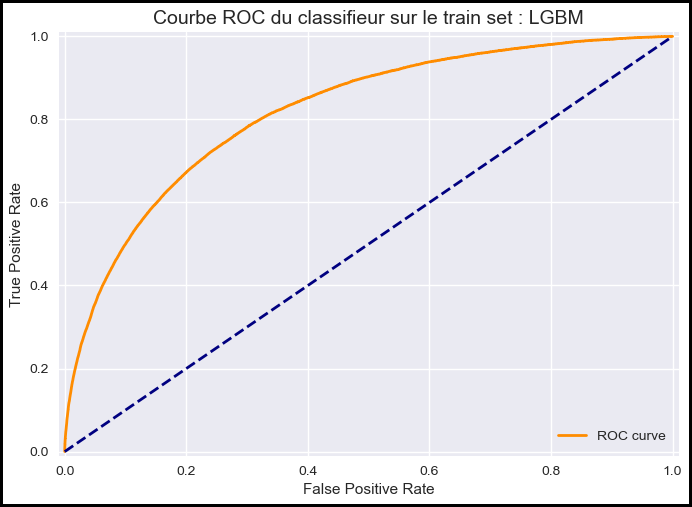

LGBM ROC AUC Score : 0.7779886617417925
LGBM AUC           : 0.8184076929953555


In [25]:
plot_ROC_curve(fpr, tpr, y_test, y_test_pred_proba, 'LGBM')

In [26]:
y_test_pred = lgbm.predict(X_test)

In [27]:
from IPython.display import HTML, display
import numpy as np

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def print_metrics(y_true, y_pred, title):

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    F1 = f1_score(y_true, y_pred)
    
    metrics_table = '<h4 style="font-size: 20px;">{}</h4>'.format(title)
    metrics_table += '<table style="font-size: 16px;"><tr><th style="text-align: left;">Metrics</th><th>Score</th></tr>'
    metrics_table += '<tr><td style="text-align: left;">{}</td><td>{:.3f}</td></tr>'.format(title + '_precision', precision)
    metrics_table += '<tr><td style="text-align: left;">{}</td><td>{:.3f}</td></tr>'.format(title + '_recall', recall)
    metrics_table += '<tr><td style="text-align: left;">{}</td><td>{:.3f}</td></tr>'.format(title + '_F1', F1)
    metrics_table += '</table>'
    display(HTML(metrics_table))

In [28]:
print_metrics(y_test, y_test_pred, 'lgbm_default')

Metrics,Score
lgbm_default_precision,0.528
lgbm_default_recall,0.026
lgbm_default_F1,0.050


In [29]:
def plot_confusion_matrix(y_test, y_pred, title):
    sns.set(style='white')
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(np.eye(2), annot=cm, fmt='g', annot_kws={'size': 14},
                cmap=sns.color_palette(['tomato', 'lightgreen'], as_cmap=True),
                cbar=False, yticklabels=['Actual 0', 'Actual 1'], xticklabels=['Predicted 0', 'Predicted 1'], ax=ax)
    
    # Get the color of the text elements in the plot
    text_color = ax.texts[0].get_color()

    # Set the background color of each cell based on its value
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            color = 'white'
            if i == j:
                if i == 0:
                    color = 'limegreen'
                else:
                    color = 'limegreen'
            else:
                if i == 0:
                    color = 'yellow'
                else:
                    color = 'red'
            ax.text(j+0.5, i+0.5, cm[i][j], ha="center", va="bottom", color=text_color, fontsize=20,
                    bbox=dict(facecolor=color, edgecolor='grey', boxstyle='round,pad=0.3'))

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(labelsize=20, length=0)
    ax.tick_params(axis='both', which='major', labelsize=14)  # Set the font size of the tick labels

    ax.set_title('Confusion Matrix - '+ str(title) + ' \n Classe 0 : prêt accordé - Classe 1 : prêt non accordé\n', size=20, pad=8)
    ax.set_xlabel('Predicted Values', size=16)
    ax.set_ylabel('Actual Values', size=16)

    additional_texts = [
        'True Negative\nPrêt accordé & client solvable',
        'False Positive\nPrêt non accordé mais client solvable\nDommage, on aurait pu donner le prêt...', 
        'False Negative\nPrêt accordé mais client non solvable\nOn n\'aurait jamais dû donner le prêt!', 
        'True Positive\nPrêt non accordé & client non solvable']
    for text_elt, additional_text in zip(ax.texts, additional_texts):
        ax.text(*text_elt.get_position(), '\n' + additional_text, color=text_elt.get_color(),
                ha='center', va='top', size=12)
    plt.tight_layout()
    plt.show()

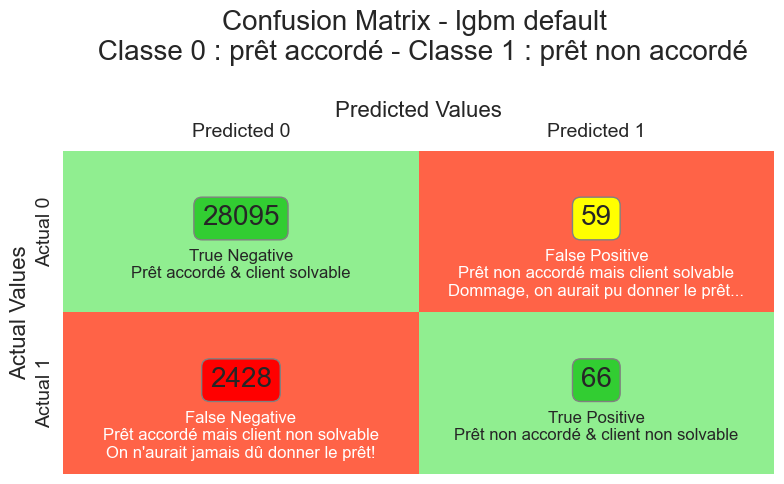

In [30]:
plot_confusion_matrix(y_test, y_test_pred, 'lgbm default')

## 2.2. Estimation des valeurs min/max des hyperparamètres de LightGBM

Hyperparamètres à faire varier:<br>
- num_leaves<br>
- num_iterations<br>
- min_data_in_leaf<br>
- learning_rate<br>
- max_depth<br>

### 2.2.1. Variations de num_leaves

In [31]:
param_grid = [{'num_leaves': [2, 5, 10, 20]}]

grid_lgbm_num_leaves_auc = GridSearchCV(lgbm,
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           return_train_score=True, n_jobs = -1)
grid_lgbm_num_leaves_auc.fit(X_train,
                y_train,
                eval_metric='auc')

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d arr

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d a

GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid=[{'num_leaves': [2, 5, 10, 20]}],
             return_train_score=True, scoring='roc_auc')

In [32]:
print("Best num_leaves hyperparameter found: ", grid_lgbm_num_leaves_auc.best_params_)

Best num_leaves hyperparameter found:  {'num_leaves': 20}


In [33]:
st = datetime.datetime.now()
param_grid = [{'num_leaves': [20, 50]}]

grid_lgbm_num_leaves_auc = GridSearchCV(lgbm,
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           return_train_score=True, n_jobs = -1)
grid_lgbm_num_leaves_auc.fit(X_train,
                y_train,
                eval_metric='auc')
et = datetime.datetime.now()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d ar

Execution time: 0:02:57.109241 seconds


In [34]:
print("Best num_leaves hyperparameter found: ", grid_lgbm_num_leaves_auc.best_params_)

Best num_leaves hyperparameter found:  {'num_leaves': 20}


On fera varier num_leaves pour les valeurs suivants : 5, 10, 20.

## 2.2.2.  Variations de num_iterations

In [35]:
st = datetime.datetime.now()
param_grid = [{'num_iterations': [5, 10, 50, 100]}]

grid_lgbm_num_iterations_auc = GridSearchCV(lgbm,
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           return_train_score=True, n_jobs = -1)
grid_lgbm_num_iterations_auc.fit(X_train,
                y_train,
                eval_metric='auc')
et = datetime.datetime.now()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d a

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

Execution time: 0:03:35.316067 seconds


In [36]:
print("Best num_iterations hyperparameter found: ", grid_lgbm_num_iterations_auc.best_params_)

Best num_iterations hyperparameter found:  {'num_iterations': 100}


In [37]:
st = datetime.datetime.now()
param_grid = [{'num_iterations': [100, 200]}]

grid_lgbm_num_iterations_auc = GridSearchCV(lgbm,
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           return_train_score=True, n_jobs = -1)
grid_lgbm_num_iterations_auc.fit(X_train,
                y_train,
                eval_metric='auc')
et = datetime.datetime.now()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d arr

Execution time: 0:03:32.477549 seconds


In [38]:
print("Best num_iterations hyperparameter found: ", grid_lgbm_num_iterations_auc.best_params_)

Best num_iterations hyperparameter found:  {'num_iterations': 200}


On fera varier num_iterations pour les valeurs suivantzs : 100, 200 (on s'arrete à 200 pour ne pas avoir des temps de calcul trop longs).

### 2.2.3. Variation de min_data_in_leaf

In [39]:
st = datetime.datetime.now()
param_grid = [{'min_data_in_leaf': [10, 20, 50, 100]}]

grid_lgbm_min_data_in_leaf_auc = GridSearchCV(lgbm,
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           return_train_score=True, n_jobs = -1)
grid_lgbm_min_data_in_leaf_auc.fit(X_train,
                y_train,
                eval_metric='auc')
et = datetime.datetime.now()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d ar

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d a

Execution time: 0:05:05.250397 seconds


In [40]:
print("Best min_data_in_leaf hyperparameter found: ", grid_lgbm_min_data_in_leaf_auc.best_params_)

Best min_data_in_leaf hyperparameter found:  {'min_data_in_leaf': 100}


On fera varier min_data_in_leaf pour les valeurs suivantes : 50, 100.

### 2.2.4. Variations de learning_rate

In [41]:
st = datetime.datetime.now()
param_grid = [{'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.4]}]

grid_lgbm_learning_rate_auc = GridSearchCV(lgbm,
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           return_train_score=True, n_jobs = -1)
grid_lgbm_learning_rate_auc.fit(X_train,
                y_train,
                eval_metric='auc')
et = datetime.datetime.now()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d a

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d a

Execution time: 0:06:14.273725 seconds


In [42]:
print("Best learning_rate hyperparameter found: ", grid_lgbm_learning_rate_auc.best_params_)

Best learning_rate hyperparameter found:  {'learning_rate': 0.1}


On fera varier learning_rate pour ces valeurs : 0.05, 0.1

### 2.2.5. Variations de max_depth

In [43]:
st = datetime.datetime.now()
param_grid = [{'max_depth': [2, 3, 5, 10]}]

grid_lgbm_max_depth_auc = GridSearchCV(lgbm,
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           return_train_score=True, n_jobs = -1)
grid_lgbm_max_depth_auc.fit(X_train,
                y_train,
                eval_metric='auc')
et = datetime.datetime.now()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d arr

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d a

Execution time: 0:04:05.614211 seconds


In [44]:
print("Best max_depth hyperparameter found: ", grid_lgbm_max_depth_auc.best_params_)

Best max_depth hyperparameter found:  {'max_depth': 10}


On fera varier max_depth entre 5 et 10.

## 2.3. GridSearchCV avec balayages des différents hyperparamètres appliqué à LightGBM sans modification des classes

### 2.3.1. Détermination des hyperparamètres optimum

In [45]:
st = datetime.datetime.now()
params = {
    'num_leaves': [5, 10, 20],
    'num_iterations': [100, 200],
    'min_data_in_leaf': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 10],    
}
grid_lgbm_multi_auc = GridSearchCV(lgbm,
                             param_grid=params,
                             scoring='roc_auc',
                             cv=5,
                             verbose = 10, n_jobs=2)
grid_lgbm_multi_auc.fit(X_train, y_train, eval_metric='auc', verbose = 6)
et = datetime.datetime.now()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning]

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d a

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

[CV 2/5; 1/48] START learning_rate=0.05, max_depth=5, min_data_in_leaf=50, num_iterations=100, num_leaves=5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[CV 2/5; 1/48] END learning_rate=0.05, max_depth=5, min_data_in_leaf=50, num_iterations=100, num_leaves=5;, score=0.751 total time=  18.7s
[CV 3/5; 1/48] START learning_rate=0.05, max_depth=5, min_data_in_leaf=50, num_iterations=100, num_leaves=5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[CV 3/5; 1/48] END learning_rate=0.05, max_depth=5, min_data_in_leaf=50, num_iterations=100, num_leaves=5;, score=0.749 total time=  19.1s
[CV 5/5; 1/48] START learning_rate=0.05, max_depth=5, min_data_in_leaf=50, num_iterations=100, num_leaves=5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[CV 5/5; 1/48] END learning_rate

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

[CV 1/5; 1/48] START learning_rate=0.05, max_depth=5, min_data_in_leaf=50, num_iterations=100, num_leaves=5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[CV 1/5; 1/48] END learning_rate=0.05, max_depth=5, min_data_in_leaf=50, num_iterations=100, num_leaves=5;, score=0.755 total time=  18.7s
[CV 4/5; 1/48] START learning_rate=0.05, max_depth=5, min_data_in_leaf=50, num_iterations=100, num_leaves=5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[CV 4/5; 1/48] END learning_rate=0.05, max_depth=5, min_data_in_leaf=50, num_iterations=100, num_leaves=5;, score=0.753 total time=  19.2s
[CV 1/5; 2/48] START learning_rate=0.05, max_depth=5, min_data_in_leaf=50, num_iterations=100, num_leaves=10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[CV 1/5; 2/48] END learning_rat

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

[CV 2/5; 18/48] END learning_rate=0.05, max_depth=10, min_data_in_leaf=50, num_iterations=200, num_leaves=20;, score=0.774 total time=  42.2s
[CV 4/5; 18/48] START learning_rate=0.05, max_depth=10, min_data_in_leaf=50, num_iterations=200, num_leaves=20
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[CV 4/5; 18/48] END learning_rate=0.05, max_depth=10, min_data_in_leaf=50, num_iterations=200, num_leaves=20;, score=0.776 total time=  42.3s
[CV 1/5; 19/48] START learning_rate=0.05, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV 1/5; 19/48] END learning_rate=0.05, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=5;, score=0.755 total time=  20.2s
[CV 2/5; 19/48] START learning_rate=0.05, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leav

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

[CV 3/5; 18/48] END learning_rate=0.05, max_depth=10, min_data_in_leaf=50, num_iterations=200, num_leaves=20;, score=0.771 total time=  41.1s
[CV 5/5; 18/48] START learning_rate=0.05, max_depth=10, min_data_in_leaf=50, num_iterations=200, num_leaves=20
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[CV 5/5; 18/48] END learning_rate=0.05, max_depth=10, min_data_in_leaf=50, num_iterations=200, num_leaves=20;, score=0.776 total time=  40.5s
[CV 3/5; 19/48] START learning_rate=0.05, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV 3/5; 19/48] END learning_rate=0.05, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=5;, score=0.749 total time=  18.5s
[CV 5/5; 19/48] START learning_rate=0.05, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leav

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

Execution time: 0:54:57.111784 seconds


In [46]:
print("Best hyperparameters settings found: ", grid_lgbm_multi_auc.best_params_)

Best hyperparameters settings found:  {'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 50, 'num_iterations': 200, 'num_leaves': 20}


### 2.3.2. Entraînement sur les meilleurs hyperparamètres trouvés pour lightGBM

In [47]:
best_params_ = grid_lgbm_multi_auc.best_params_

In [48]:
best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_data_in_leaf': 50,
 'num_iterations': 200,
 'num_leaves': 20}

In [49]:
lgbm_opti = LGBMClassifier(**best_params_)

In [50]:
lgbm_opti.fit(X_train,
              y_train,
              eval_metric='auc',
              verbose=6)

LGBMClassifier(max_depth=5, min_data_in_leaf=50, num_iterations=200,
               num_leaves=20)

In [51]:
y_test_pred_proba_opti = lgbm_opti.predict_proba(X_test)
y_train_pred_proba_opti = lgbm_opti.predict_proba(X_train)
fpr_opti, tpr_opti, thr_opti = roc_curve(y_train, y_train_pred_proba_opti[:, 1])

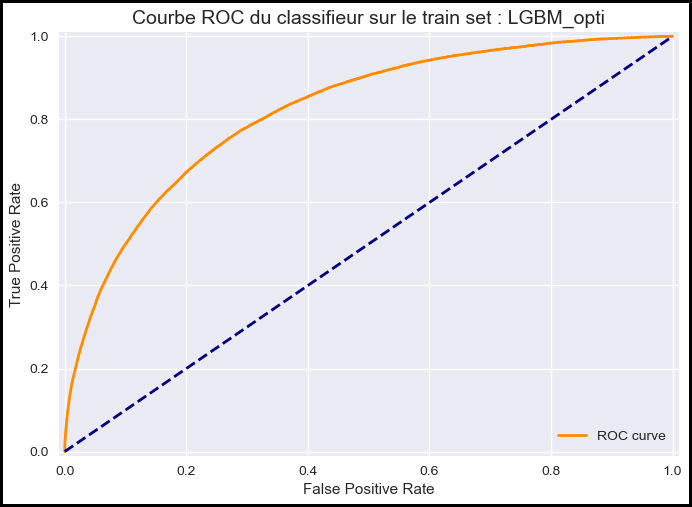

LGBM_opti ROC AUC Score : 0.7814005869539049
LGBM_opti AUC           : 0.8201773131904491


In [574]:
from IPython.display import display, HTML
plt.style.use('seaborn')
plot_ROC_curve(fpr_opti, tpr_opti, y_test, y_test_pred_proba_opti, 'LGBM_opti')

In [53]:
y_test_pred_opti = lgbm_opti.predict(X_test)

In [54]:
print_metrics(y_test, y_test_pred_opti, 'lgbm_opti')

Metrics,Score
lgbm_opti_precision,0.542
lgbm_opti_recall,0.034
lgbm_opti_F1,0.063


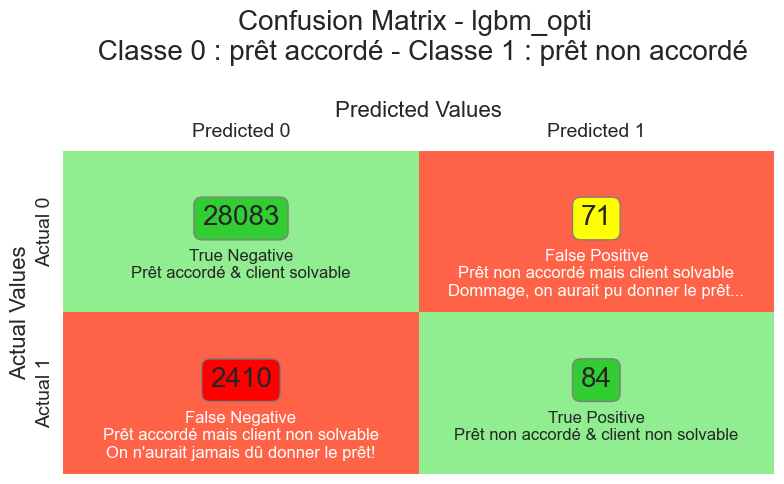

In [55]:
plot_confusion_matrix(y_test, y_test_pred_opti, 'lgbm_opti')

# 3. Traitement du déséquilibre des classes

## 3.1. Utilisation de class_weight

### 3.1.1. GridsearchCV pour identifier les valeurs de class_weight qui conviennent

In [56]:
st = datetime.datetime.now()
weights = np.linspace(0.05, 0.95, 10)
params = {
    'learning_rate': [0.1],
    'max_depth': [5],
    'min_data_in_leaf': [50],
    'num_iterations': [200],
    'num_leaves': [20],
    'class_weight': [{0: x, 1: 1.0-x} for x in weights]}
grid_lgbm_opti_class_weight_auc = GridSearchCV(lgbm,
                             param_grid=params,
                             scoring='roc_auc',
                             cv=5,
                             verbose = 10, n_jobs=-1)

grid_lgbm_opti_class_weight_auc.fit(X_train, y_train, eval_metric='auc', verbose = 6)
et = datetime.datetime.now()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

[CV 1/5; 36/48] START learning_rate=0.1, max_depth=5, min_data_in_leaf=100, num_iterations=200, num_leaves=20
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV 1/5; 36/48] END learning_rate=0.1, max_depth=5, min_data_in_leaf=100, num_iterations=200, num_leaves=20;, score=0.778 total time=  33.8s
[CV 3/5; 36/48] START learning_rate=0.1, max_depth=5, min_data_in_leaf=100, num_iterations=200, num_leaves=20
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV 3/5; 36/48] END learning_rate=0.1, max_depth=5, min_data_in_leaf=100, num_iterations=200, num_leaves=20;, score=0.773 total time=  34.0s
[CV 5/5; 36/48] START learning_rate=0.1, max_depth=5, min_data_in_leaf=100, num_iterations=200, num_leaves=20
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV 5/5; 36/48] 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d ar

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWa

/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moninechan/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/moninechan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Execution time: 0:14:51.519993 seconds


In [57]:
print("Best hyperparameters settings and class_weight found: ", grid_lgbm_opti_class_weight_auc.best_params_)

Best hyperparameters settings and class_weight found:  {'class_weight': {0: 0.35, 1: 0.65}, 'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 50, 'num_iterations': 200, 'num_leaves': 20}


### 3.1.2. Entraînement sur les meilleurs valeurs de class_weight

In [58]:
best_params_class_weight = grid_lgbm_opti_class_weight_auc.best_params_

In [59]:
best_params_class_weight

{'class_weight': {0: 0.35, 1: 0.65},
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_data_in_leaf': 50,
 'num_iterations': 200,
 'num_leaves': 20}

In [60]:
lgbm_opti_class_weight = LGBMClassifier(**best_params_class_weight)

In [61]:
lgbm_opti_class_weight.fit(X_train,
              y_train,
              eval_metric='auc',
              verbose=6)

LGBMClassifier(class_weight={0: 0.35, 1: 0.65}, max_depth=5,
               min_data_in_leaf=50, num_iterations=200, num_leaves=20)

In [62]:
y_test_pred_proba_opti_class_weight = lgbm_opti_class_weight.predict_proba(X_test)
y_train_pred_proba_opti_class_weight = lgbm_opti_class_weight.predict_proba(X_train)
fpr_opti_class_weight, tpr_opti_class_weight, thr_opti_class_weight = roc_curve(y_train, y_train_pred_proba_opti_class_weight[:, 1])

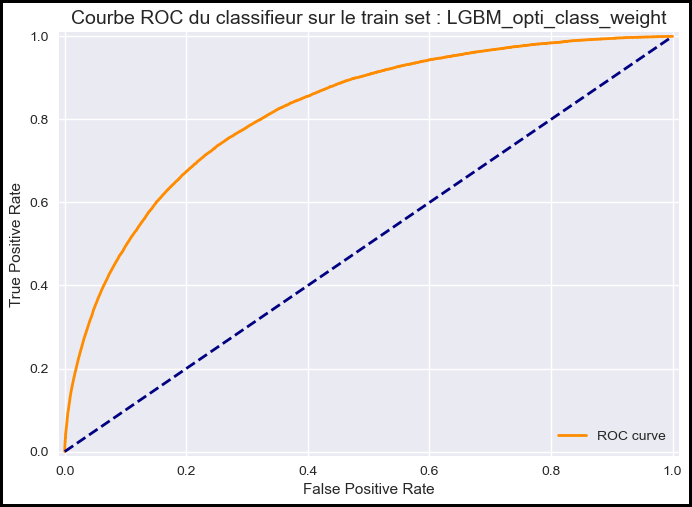

LGBM_opti_class_weight ROC AUC Score : 0.7819678359696431
LGBM_opti_class_weight AUC           : 0.8204949678608389


In [575]:
from IPython.display import display, HTML
plt.style.use('seaborn')
plot_ROC_curve(fpr_opti_class_weight, tpr_opti_class_weight, y_test, y_test_pred_proba_opti_class_weight, 'LGBM_opti_class_weight')

In [64]:
y_test_pred_opti_class_weight = lgbm_opti_class_weight.predict(X_test)

In [65]:
print_metrics(y_test, y_test_pred_opti_class_weight, 'lgbm_opti_class_weight')

Metrics,Score
lgbm_opti_class_weight_precision,0.455
lgbm_opti_class_weight_recall,0.111
lgbm_opti_class_weight_F1,0.179


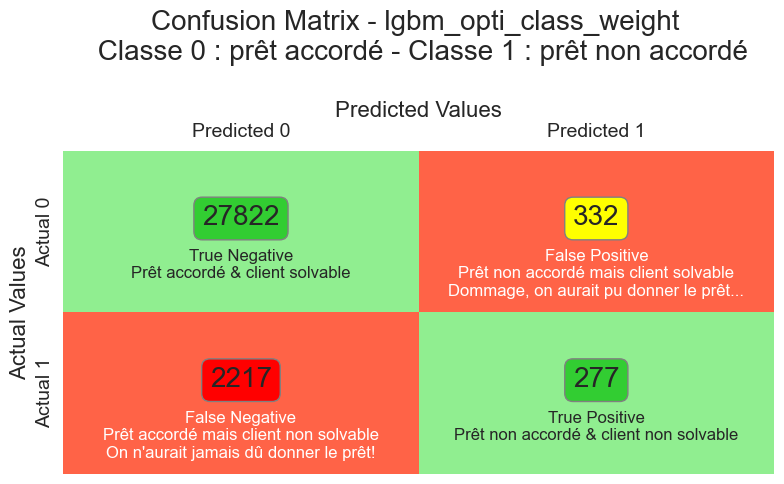

In [66]:
plot_confusion_matrix(y_test, y_test_pred_opti_class_weight, 'lgbm_opti_class_weight')

Par rapport au cas où les classes ne sont pas équilibrées, on observe une diminutation des FN ce qui est souhaitable. <br>
Dans la mesure où l'on souhaite miniser les FN, on privilégiera un score plus élevé de recall - on verra aussi une augmentation des FP mais ceux-ci sont plus acceptables que la présence de FN.

## 3.2. Utilisation d'une méthode de rééquilibrage par undersampling avec imblearn

### 3.2.1. Mise en place du undersampling

In [67]:
rus = RandomUnderSampler(random_state=42, replacement=True)

In [68]:
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [69]:
y_train_rus.shape

(44490, 1)

In [70]:
y_train.shape

(275823, 1)

In [71]:
X_train_rus.shape

(44490, 193)

In [72]:
X_train.shape

(275823, 193)

In [73]:
y_train_target_1 = y_train.loc[y_train['TARGET'] == 1]

In [74]:
y_train_target_0 = y_train.loc[y_train['TARGET'] == 0]

In [75]:
y_train_target_1.shape

(22245, 1)

In [76]:
y_train_target_0.shape

(253578, 1)

In [77]:
22245 + 253578

275823

La technique d'undersampling prends la totalité des observations de la classe minoritaire (TARGET = 1) et ajoute le même nombre d'observations pour la classe majoritaire (TARGET = 0)

### 3.2.2. Entraînement sur les meilleurs valeurs de LGBM Opti sur les données de l'undersampling

In [78]:
lgbm_opti_rus = LGBMClassifier(**best_params_)

In [79]:
lgbm_opti_rus

LGBMClassifier(max_depth=5, min_data_in_leaf=50, num_iterations=200,
               num_leaves=20)

In [80]:
lgbm_opti_rus.fit(X_train_rus,
              y_train_rus,
              eval_metric='auc',
              verbose=6)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


LGBMClassifier(max_depth=5, min_data_in_leaf=50, num_iterations=200,
               num_leaves=20)

In [81]:
y_test_pred_proba_opti_rus = lgbm_opti_rus.predict_proba(X_test)
y_train_pred_proba_opti_rus = lgbm_opti_rus.predict_proba(X_train_rus)
fpr_opti_rus, tpr_opti_rus, thr_opti_rus = roc_curve(y_train_rus, y_train_pred_proba_opti_rus[:, 1])

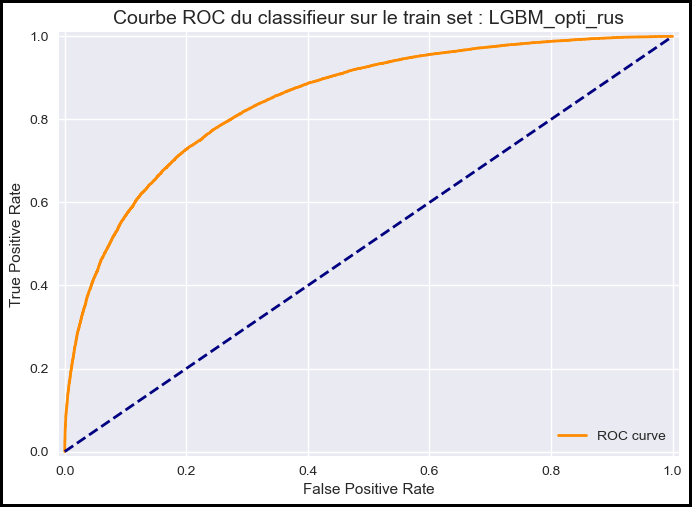

LGBM_opti_rus ROC AUC Score : 0.778705249777843
LGBM_opti_rus AUC           : 0.8475744681324031


In [577]:
from IPython.display import display, HTML
plt.style.use('seaborn')
plot_ROC_curve(fpr_opti_rus, tpr_opti_rus, y_test, y_test_pred_proba_opti_rus, 'LGBM_opti_rus')

In [83]:
y_test_pred_opti_rus = lgbm_opti_rus.predict(X_test)

In [84]:
print_metrics(y_test, y_test_pred_opti_rus, 'lgbm_opti_rus')

Metrics,Score
lgbm_opti_rus_precision,0.178
lgbm_opti_rus_recall,0.724
lgbm_opti_rus_F1,0.286


La précision est vraiment très mauvaise avec Random UnderSampling

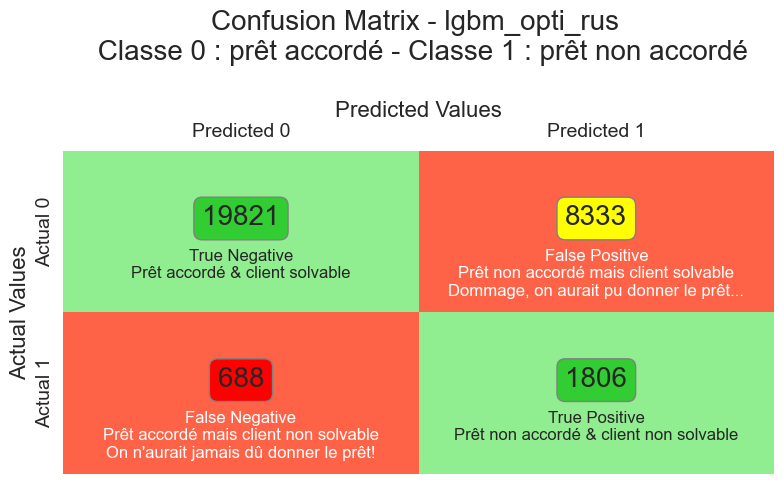

In [85]:
plot_confusion_matrix(y_test, y_test_pred_opti_rus , 'lgbm_opti_rus')

Le nombre de FN est bien diminué mais on refuse beaucoup trop de clients qui auraient mérité le prêt. <br>
La précision est trop mauvaise. On ne retiendra pas cette technique d'undersampling

# 4. Création d'une fonction de coût métier

## 4.1. Définition de la  fonction coût métier

In [86]:
def cout_metier(FN, FP):
    return (FN + 10 * FP)

On considère que la présence d'un faux négatif (personne non solvable qui s'est vu attribuée un prêt) est 10 fois plus coûteuse que la présence d'un faux positif (personne solvable qui s'est vu refusée un prêt).<br>
Le but va être de trouver le seuil (entre 0 et 1) de la probabilité que le client fasse défaut qui va minimiser le coût.<br>

## 4.2. Application de la fonction coût métier sur LGBM optimisé avec GridsearchCV sans prise en compte du déséquilibre des classes

### 4.2.1. Préparation des données d'entrée pour le calcul du coût métier

In [87]:
y_train_pred_proba_opti.shape

(275823, 2)

In [88]:
y_train_pred_proba_opti

array([[0.94787617, 0.05212383],
       [0.9314342 , 0.0685658 ],
       [0.90844814, 0.09155186],
       ...,
       [0.82466968, 0.17533032],
       [0.71064177, 0.28935823],
       [0.98866236, 0.01133764]])

In [89]:
index_x_train = X_train.index

In [90]:
len(index_x_train)

275823

In [91]:
type(index_x_train)

pandas.core.indexes.numeric.Int64Index

In [92]:
index_x_train_series = pd.Series(index_x_train.values, index=index_x_train)

In [93]:
type(index_x_train_series)

pandas.core.series.Series

In [94]:
index_x_train_series.shape

(275823,)

In [95]:
SK_ID_CURR_X_train = X_train['SK_ID_CURR']

In [96]:
len(SK_ID_CURR_X_train )

275823

In [97]:
type(SK_ID_CURR_X_train)

pandas.core.series.Series

In [98]:
index_x_train_list = index_x_train_series.tolist()

In [99]:
len(index_x_train_list)

275823

In [100]:
df_train_set_pred_proba_opti = pd.DataFrame({
    'SK_ID_CURR':
    index_x_train_list,
    'pred_proba':
    y_train_pred_proba_opti[:, 1].tolist(),
    'TARGET_True':
    y_train['TARGET'].astype(int)
})

In [101]:
df_train_set_pred_proba_opti.head()

,SK_ID_CURR,pred_proba,TARGET_True
114195,114195,0.052124,0
53335,53335,0.068566,0
118514,118514,0.091552,0
157507,157507,0.022239,0
45029,45029,0.177644,0


### 4.2.2. Calcul de la fonction coût métier et du seuil de probabilité pour minimiser le coût sur LGBM optimisé avec GridsearchCV sans prise en compte du déséquilibre des classes

In [102]:
def cout_modelise(seuil, df, verbose=False):
    "Retourne le coût métier en fonction du seuil."
    ser_TARGET_pred = (df['pred_proba'] > seuil).astype(int)
    TP = ((df['TARGET_True'] == 1) &
          (ser_TARGET_pred == 1)).sum()
    TN = ((df['TARGET_True'] == 0) &
          (ser_TARGET_pred == 0)).sum()
    FP = ((df['TARGET_True'] == 0) &
          (ser_TARGET_pred == 1)).sum()
    FN = ((df['TARGET_True'] == 1) &
          (ser_TARGET_pred == 0)).sum()
    if verbose:
        return TP, TN, FP, FN, cout_metier(FP, FN)
    else:
        return cout_metier(FP, FN)

In [103]:
seuils_LGBM_opti = np.linspace(0, 1, 1001)
couts_modelises_LGBM_opti = [cout_modelise(seuil, df_train_set_pred_proba_opti) for seuil in seuils_LGBM_opti]

# Quelle est la valeur de seuil qui conduit au minimum de la fonction coût métier ?
min_value_train_LGBM_opti = min(couts_modelises_LGBM_opti)
min_index_LGBM_opti = couts_modelises_LGBM_opti.index(min_value_train_LGBM_opti)
min_seuil_LGBM_opti = seuils_LGBM_opti[min_index_LGBM_opti]
print("Seuil qui conduit au minimum de la fonction coût métier :", min_seuil_LGBM_opti)
print("Valeur minimum de la fonction coût métier :", round(min_value_train_LGBM_opti, 2))

Seuil qui conduit au minimum de la fonction coût métier : 0.093
Valeur minimum de la fonction coût métier : 122642


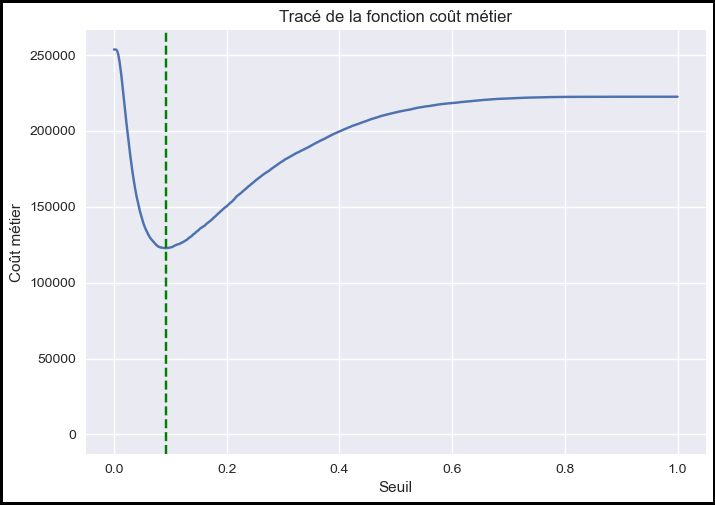

In [578]:
from IPython.display import display, HTML
plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4)
plt.plot(seuils_LGBM_opti, couts_modelises_LGBM_opti)
plt.xlabel('Seuil')
plt.ylabel('Coût métier')
plt.title('Tracé de la fonction coût métier')
plt.axline((min_seuil_LGBM_opti, 0), (min_seuil_LGBM_opti, 1), c='green', ls='dashed')
plt.show()

Il faut donc diminuer le seuil de probabilité pour la classification binaire de 0.5 (seuil par défaut de la méthode predict de LighGBM) à 0.093 pour minimiser le coût.

In [105]:
# Quelle est la matrice de confusion à l'optimum ?
TP_cout_opti, TN_cout_opti, FP_cout_opti, FN_cout_opti, _ = cout_modelise(0.093, df_train_set_pred_proba_opti, verbose=True)

display(
    pd.DataFrame([[TN_cout_opti, FP_cout_opti], [FN_cout_opti, TP_cout_opti]],
                 columns=['Predicted 0', 'Predicted 1'],
                 index=['Actual 0', 'Actual 1']))

,Predicted 0,Predicted 1
Actual 0,194796,58782
Actual 1,6386,15859


In [106]:
def precision(TP, FP):
    return TP / (TP + FP)

def recall(TP, FN):
    return TP / (TP + FN)

def f1_score(TP, FP, FN):
    p = precision(TP, FP)
    r = recall(TP, FN)
    return 2 * (p * r) / (p + r)

In [107]:
lgbm_opti_seuil_min_precision = precision(TP_cout_opti, FP_cout_opti)
lgbm_opti_seuil_min_recall = recall(TP_cout_opti, FN_cout_opti)
lgbm_opti_seuil_min_f1_score = f1_score(TP_cout_opti, FP_cout_opti, FN_cout_opti)

In [108]:
print("lgbm_opti_seuil_min_precision :", lgbm_opti_seuil_min_precision)
print("lgbm_opti_seuil_min_recall    :", lgbm_opti_seuil_min_recall)
print("lgbm_opti_seuil_min_f1_score  :", lgbm_opti_seuil_min_f1_score)

lgbm_opti_seuil_min_precision : 0.21247035811417317
lgbm_opti_seuil_min_recall    : 0.712924252641043
lgbm_opti_seuil_min_f1_score  : 0.3273744400635799


## 4.3. Application de la fonction coût métier sur LGBM optimisé avec GridsearchCV avec prise en compte du déséquilibre des classes via class_weight

### 4.3.1. Préparation des données d'entrée pour le calcul du coût métier

In [109]:
y_train_pred_proba_opti_class_weight.shape

(275823, 2)

In [110]:
df_train_set_pred_proba_opti_class_weight = pd.DataFrame({
    'SK_ID_CURR':
    index_x_train_list,
    'pred_proba':
    y_train_pred_proba_opti_class_weight[:, 1].tolist(),
    'TARGET_True':
    y_train['TARGET'].astype(int)
})

### 4.3.2. Calcul de la fonction coût métier et du seuil de probabilité pour minimiser le coût sur LGBM optimisé avec GridsearchCV sans prise en compte du déséquilibre des classes

In [111]:
seuils_LGBM_opti_class_weight = np.linspace(0, 1, 1001)
couts_modelises_LGBM_opti_class_weight = [cout_modelise(seuil, df_train_set_pred_proba_opti_class_weight) for seuil in seuils_LGBM_opti_class_weight]

# Quelle est la valeur de seuil qui conduit au minimum de la fonction coût métier ?
min_value_train_LGBM_opti_class_weight = min(couts_modelises_LGBM_opti_class_weight)
min_index_LGBM_opti_class_weight = couts_modelises_LGBM_opti_class_weight.index(min_value_train_LGBM_opti_class_weight)
min_seuil_LGBM_opti_class_weight = seuils_LGBM_opti_class_weight[min_index_LGBM_opti_class_weight]
print("Seuil qui conduit au minimum de la fonction coût métier :", min_seuil_LGBM_opti_class_weight)
print("Valeur minimum de la fonction coût métier :", round(min_value_train_LGBM_opti_class_weight, 2))

Seuil qui conduit au minimum de la fonction coût métier : 0.159
Valeur minimum de la fonction coût métier : 122198


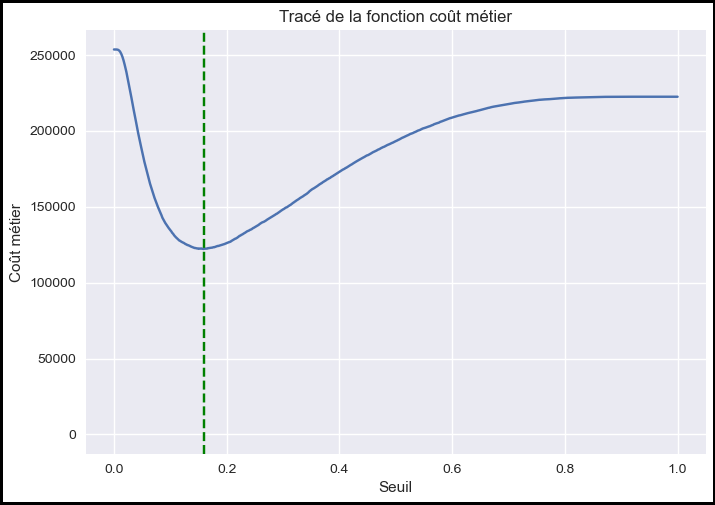

In [579]:
from IPython.display import display, HTML
plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4)
plt.plot(seuils_LGBM_opti_class_weight, couts_modelises_LGBM_opti_class_weight)
plt.xlabel('Seuil')
plt.ylabel('Coût métier')
plt.title('Tracé de la fonction coût métier')
plt.axline((min_seuil_LGBM_opti_class_weight, 0), (min_seuil_LGBM_opti_class_weight, 1), c='green', ls='dashed')
plt.show()

Le seuil qui conduit au minimum de la fonction coût métier est : 0.159

In [113]:
# Quelle est la matrice de confusion à l'optimum ?
TP_cout_opti_class_weight, TN_cout_opti_class_weight, FP_cout_opti_class_weight, FN_cout_opti_class_weight, _ = cout_modelise(0.159, df_train_set_pred_proba_opti, verbose=True)

display(
    pd.DataFrame([[TN_cout_opti_class_weight, FP_cout_opti_class_weight], [FN_cout_opti_class_weight, TP_cout_opti_class_weight]],
                 columns=['Predicted 0', 'Predicted 1'],
                 index=['Actual 0', 'Actual 1']))

,Predicted 0,Predicted 1
Actual 0,228766,24812
Actual 1,11229,11016


In [114]:
lgbm_opti_class_weight_seuil_min_precision = precision(TP_cout_opti_class_weight, FP_cout_opti_class_weight)
lgbm_opti_class_weight_seuil_min_recall = recall(TP_cout_opti_class_weight, FN_cout_opti_class_weight)
lgbm_opti_class_weight_seuil_min_f1_score = f1_score(TP_cout_opti_class_weight, FP_cout_opti_class_weight, FN_cout_opti_class_weight)

In [115]:
print("lgbm_opti_class_weight_seuil_min_precision :", lgbm_opti_class_weight_seuil_min_precision)
print("lgbm_opti_class_weight_seuil_min_recall    :", lgbm_opti_class_weight_seuil_min_recall)
print("lgbm_opti_class_weight_seuil_min_f1_score  :", lgbm_opti_class_weight_seuil_min_f1_score)

lgbm_opti_class_weight_seuil_min_precision : 0.3074690186446355
lgbm_opti_class_weight_seuil_min_recall    : 0.4952124072825354
lgbm_opti_class_weight_seuil_min_f1_score  : 0.3793845676992751


# 5. Evaluations des performances sur le jeu de données de validation non utilisé pour l'entraînement (avec TARGET): df_valid_tt

On va comparer les performances des deux modèles suivants:<br>
- LGBM avec hyperparamètres optimisés <u>sans</u> prise en compte du déséquilibre des classes,<br>
- LGBM avec hyperparamètres optimisés <u>avec</u> prise en compte du déséquilibre des classes,<br>
sur un jeu de données, qui n'a pas été utilisé pour l'entraînement mais qui comporte aussi TARGET : <b>df_valid_tt</b>.<br><br>

NB : pour rappel,<br>
- df_train_test : jeu de données pour l'entraînement et la validation croisées GridSearchCV (avec TARGET),<br>
- df_valid : jeu de données pour la compétition Kaggle (sans TARGET).<br>

In [116]:
df_valid_tt = pd.read_csv('df_valid_tt.csv', compression = 'gzip', index_col = 0)

In [117]:
df_valid_tt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 144164 to 298448
Columns: 194 entries, AMT_ANNUITY to index
dtypes: float64(138), int64(56)
memory usage: 1.5 MB


In [118]:
df_valid_tt.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,ANNUITY_INCOME_PERC,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_CNT_CREDIT_PROLONG_SUM,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EMERGENCYSTATE_MODE,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,INCOME_CREDIT_PERC,INCOME_PER_PERSON,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_SUM,INSTAL_COUNT,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,PAYMENT_RATE,POS_COUNT,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_MIN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_DAYS_DECISION_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_H

In [119]:
X_valid_tt = df_valid_tt.drop(columns='TARGET')

In [120]:
y_valid_tt = df_valid_tt[['TARGET']]

## 5.1. Performances avec le modèle LightGBM optimisé sans prise en compte du déséquilibre des classes

In [121]:
y_pred_proba_valid_tt = lgbm_opti.predict_proba(X_valid_tt)

In [122]:
fpr_valid_tt, tpr_valid_tt, thr_valid_tt = roc_curve(y_valid_tt, y_pred_proba_valid_tt [:, 1])

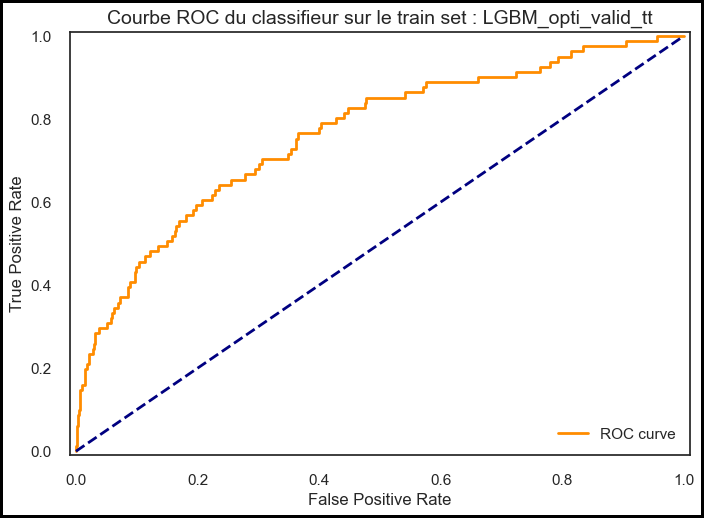

LGBM_opti_valid_tt ROC AUC Score : 0.7628931071078333
LGBM_opti_valid_tt AUC           : 0.7628931071078333


In [123]:
plot_ROC_curve(fpr_valid_tt, tpr_valid_tt, y_valid_tt, y_pred_proba_valid_tt, 'LGBM_opti_valid_tt')

In [124]:
y_pred_valid_tt = lgbm_opti.predict(X_valid_tt)

In [127]:
from sklearn.metrics import f1_score
print_metrics(y_valid_tt, y_pred_valid_tt, 'lgbm_opti_valid_tt')

Metrics,Score
lgbm_opti_valid_tt_precision,0.750
lgbm_opti_valid_tt_recall,0.037
lgbm_opti_valid_tt_F1,0.071


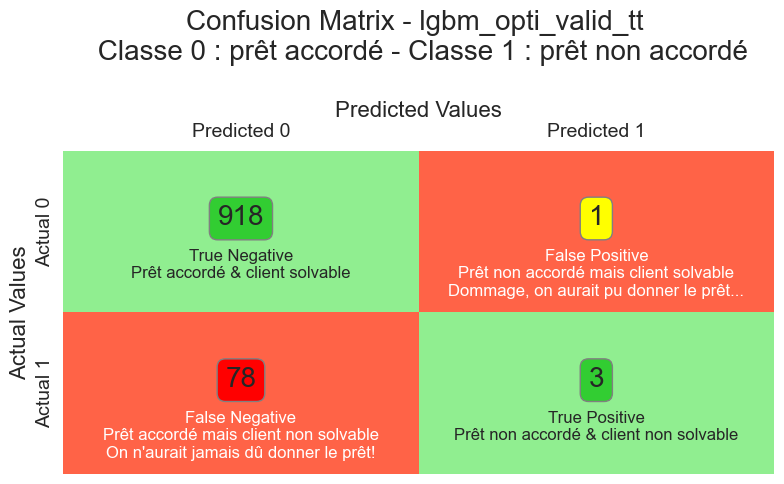

In [128]:
plot_confusion_matrix(y_valid_tt, y_pred_valid_tt , 'lgbm_opti_valid_tt')

## 5.2. Performances avec le modèle LightGBM optimisé avec prise en compte du déséquilibre des classes (class_weight)

In [129]:
y_pred_proba_valid_tt_class_weight = lgbm_opti_class_weight.predict_proba(X_valid_tt)

In [130]:
fpr_valid_tt_class_weight, tpr_valid_tt_class_weight, thr_valid_tt_class_weight = roc_curve(y_valid_tt, y_pred_proba_valid_tt_class_weight[:, 1])

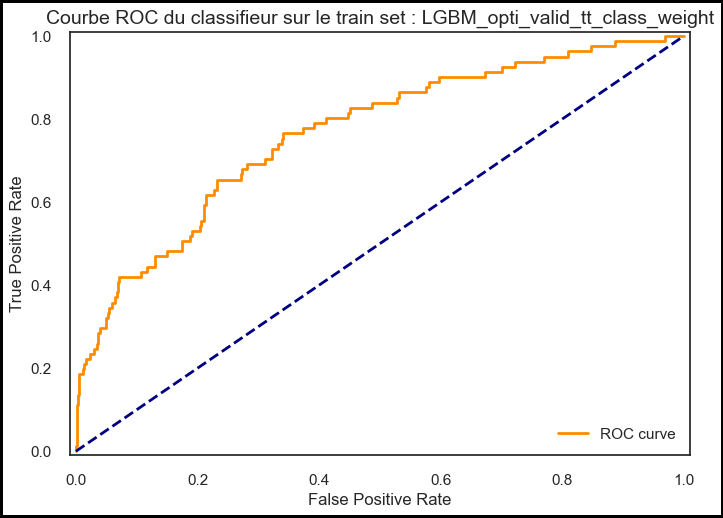

LGBM_opti_valid_tt_class_weight ROC AUC Score : 0.7660097529520816
LGBM_opti_valid_tt_class_weight AUC           : 0.7660097529520816


In [131]:
plot_ROC_curve(fpr_valid_tt_class_weight, tpr_valid_tt_class_weight, y_valid_tt, y_pred_proba_valid_tt_class_weight, 'LGBM_opti_valid_tt_class_weight')

In [132]:
y_pred_valid_tt_class_weight = lgbm_opti_class_weight.predict(X_valid_tt)

In [133]:
print_metrics(y_valid_tt, y_pred_valid_tt_class_weight, 'lgbm_opti_valid_tt_class_weight')

Metrics,Score
lgbm_opti_valid_tt_class_weight_precision,0.786
lgbm_opti_valid_tt_class_weight_recall,0.136
lgbm_opti_valid_tt_class_weight_F1,0.232


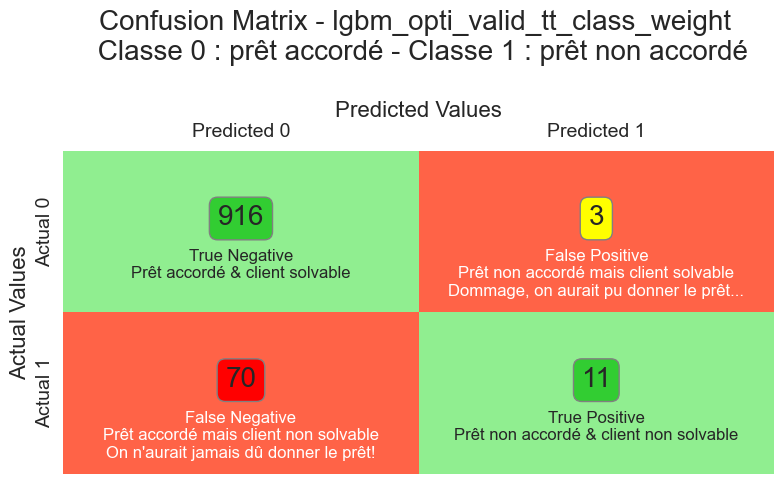

In [134]:
plot_confusion_matrix(y_valid_tt, y_pred_valid_tt_class_weight , 'lgbm_opti_valid_tt_class_weight')

### Conclusion :

C'est bien la version du modèle LightGBM optimisé avec prise en compte du déséquilibre des classes qui a les meilleurs performances sur des données non vues en entraînement, dont on rappelle les paramètres ci-dessous: <br>

In [361]:
lgbm_opti_class_weight

LGBMClassifier(class_weight={0: 0.35, 1: 0.65}, max_depth=5,
               min_data_in_leaf=50, num_iterations=200, num_leaves=20)

De plus, on appliquera un seuil de 0.159 pour la prédiction de la classe afin de minimiser le coût métier.

# 6. Importance des features

## 6.1. Importance des features globales

In [135]:
global_features_importance_scores = lgbm_opti_class_weight.feature_importances_

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

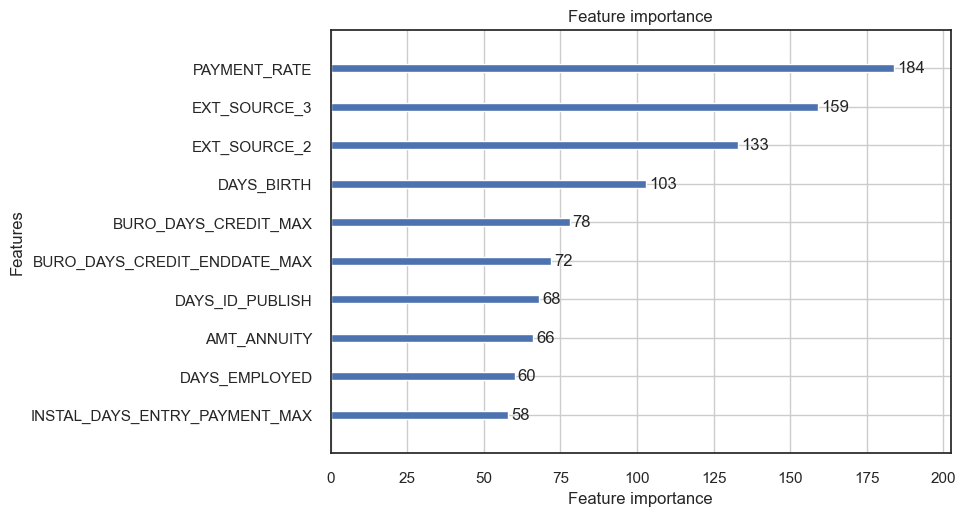

In [136]:
plot_importance(lgbm_opti, max_num_features=10, importance_type='split')

## 6.2. Importance des features locales avec SHAP

In [137]:
shap.initjs()  # nécessaire pour tracer les force plots

In [138]:
lgbm_opti_class_weight_explainer = shap.Explainer(lgbm_opti_class_weight, X_train, check_additivity=False)

In [139]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (275823, 193)
Shape of X_test: (30648, 193)


In [227]:
X_test_sample = X_test.sample(n=10000, replace=False, random_state=42)

In [231]:
X_test_sample = X_test_sample.drop(X_test_sample[X_test_sample['index'] == 270319].index)

In [314]:
X_test_sample = X_test_sample.drop(X_test_sample[X_test_sample['index'] == 296428].index)

In [315]:
shap_values = lgbm_opti_class_weight_explainer.shap_values(X_test_sample)

100%|===================| 9965/9998 [01:16<00:00]        

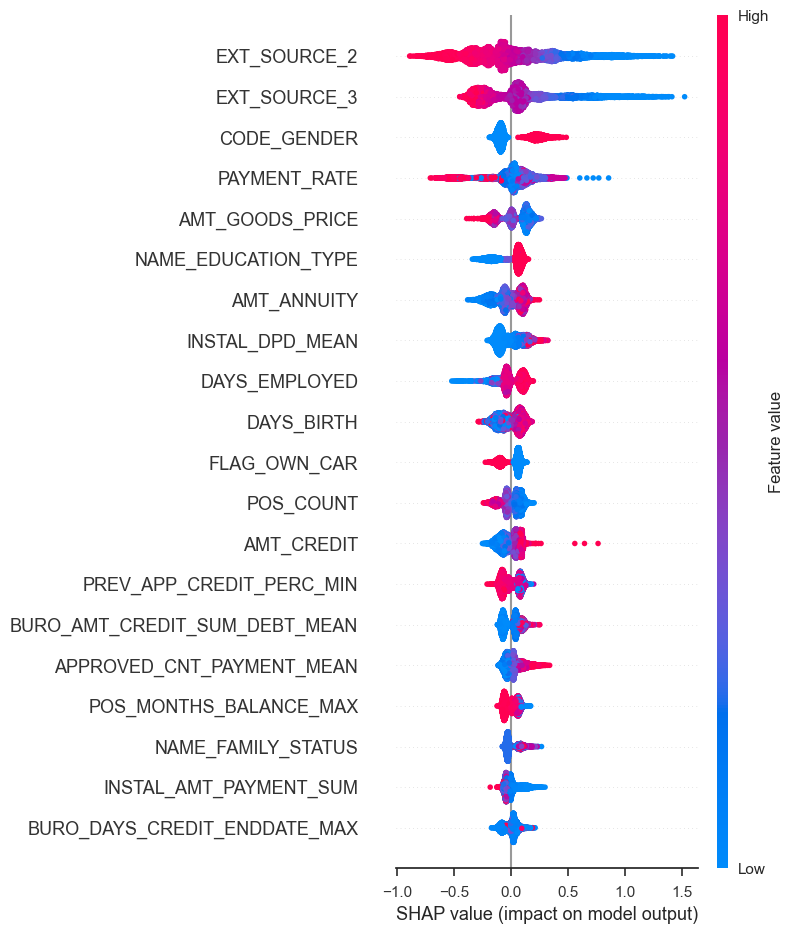

In [316]:
shap.summary_plot(shap_values, X_test_sample)

In [317]:
shap_values_for_waterfall = lgbm_opti_class_weight_explainer(X_test_sample)

 99%|===================| 9863/9998 [01:16<00:01]        

In [318]:
type(shap_values_for_waterfall)

shap._explanation.Explanation

In [319]:
type(lgbm_opti_class_weight_explainer)

shap.explainers._tree.Tree

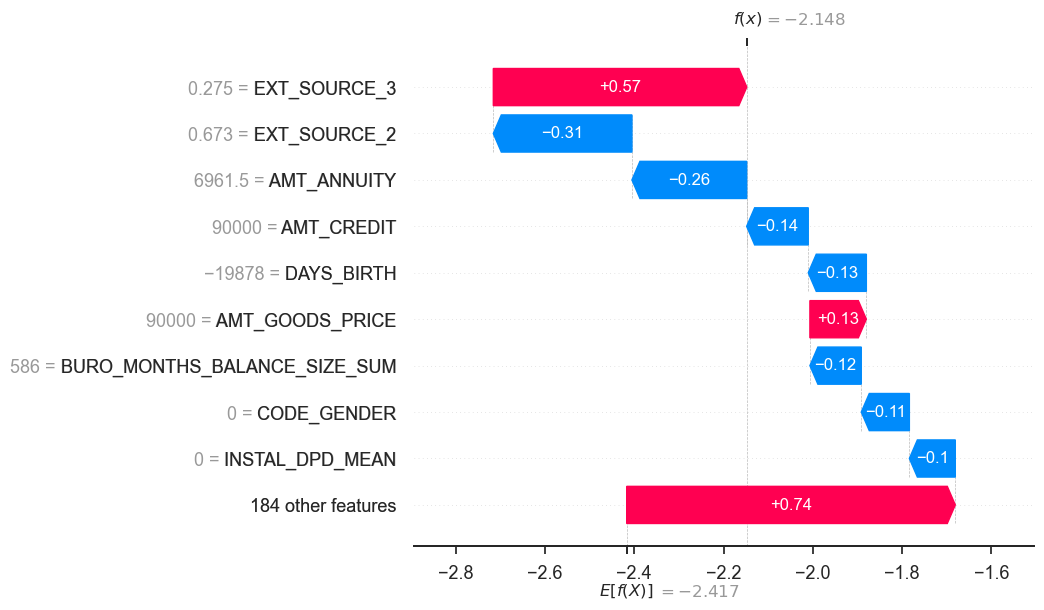

In [320]:
shap.plots.waterfall(shap_values_for_waterfall[0])

In [ ]:
# Serialize the explanation object and save it to a file
with open('shap_values_for_waterfall.pkl', 'wb') as f:
    pickle.dump(shap_values_for_waterfall, f)

In [ ]:
# Load the serialized explanation object from the saved file
with open('shap_values_for_waterfall.pkl', 'rb') as f:
    explanation = pickle.load(f)

In [ ]:
shap.plots.waterfall(explanation[5])

# 7. Pipeline de prédiction

In [321]:
pipeline = pipeline.Pipeline([('LightGBM', LGBMClassifier(**best_params_class_weight))])

In [322]:
pipeline.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


Pipeline(steps=[('LightGBM',
                 LGBMClassifier(class_weight={0: 0.35, 1: 0.65}, max_depth=5,
                                min_data_in_leaf=50, num_iterations=200,
                                num_leaves=20))])

In [323]:
pipeline.score(X_test, y_test)

0.91682980944923

# 8. Sérialisation du pipeline

On créé un fichier binaire qui contient le modèle entraîné.

In [324]:
joblib.dump(pipeline, 'pipeline_home_loan_score.joblib')

['pipeline_home_loan_score.joblib']

# 9. Stockage du modèle avec MLflow

## 9.1. Extraction de la signature du modèle

On extrait le nombre et le type des données en entrée et en sortie du modèle.

In [325]:
signature = infer_signature(X_train, y_train)

## 9.2. Sauvegarde du modèle sklearn

In [377]:
mlflow.sklearn.save_model(pipeline, 'mlflow_model', signature=signature)

## 9.3. Lancement de l'API en local

mlflow models serve -m mlflow_model/

# 10. Prédiction du jeu de données pour la compétition Kaggle (sans TARGET): df_valid

In [327]:
df_valid = pd.read_csv('df_valid_NaN_proofed_Encoded.csv', compression = 'gzip', index_col = 0)

In [328]:
X_valid = df_valid.drop(columns='TARGET')

In [329]:
X_valid.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,ANNUITY_INCOME_PERC,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_CNT_CREDIT_PROLONG_SUM,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EMERGENCYSTATE_MODE,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,INCOME_CREDIT_PERC,INCOME_PER_PERSON,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_SUM,INSTAL_COUNT,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,PAYMENT_RATE,POS_COUNT,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_MIN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_DAYS_DECISION_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_H

In [330]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 307511 to 356254
Columns: 193 entries, AMT_ANNUITY to index
dtypes: float64(137), int64(56)
memory usage: 72.1 MB


In [331]:
y_valid_pred_proba = lgbm_opti_class_weight.predict_proba(X_valid)

In [332]:
submission = pd.DataFrame({
    'SK_ID_CURR': df_valid['SK_ID_CURR'],
    'TARGET' : y_valid_pred_proba[:,1]
})

In [333]:
submission.head()

,SK_ID_CURR,TARGET
307511,100001,0.125386
307512,100005,0.340704
307513,100013,0.046750
307514,100028,0.071094
307515,100038,0.243875


In [334]:
submission.to_csv('lgbm_opti_df_valid.csv', index=False)

In [335]:
!kaggle competitions submit - c home-credit-default-risk - f lgbm_opti_df_valid.csv - m "lgbm_opti_df_valid"

zsh:1: command not found: kaggle


Le modèle lgbm_opti_class_weight a été soumis en "late submission" dans la compétition Kaggle (en dehors de ce notebook) en chargeant le fichier 'lgbm_opti_df_valid.csv' sur la page Kaggle de la compétition : https://www.kaggle.com/c/home-credit-default-risk/data.<br>
Voici les scores obtenus :

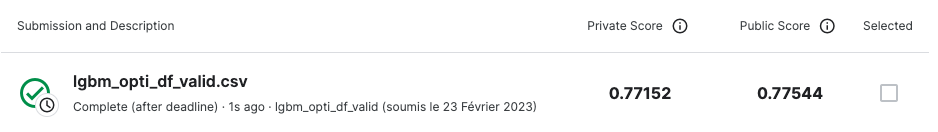

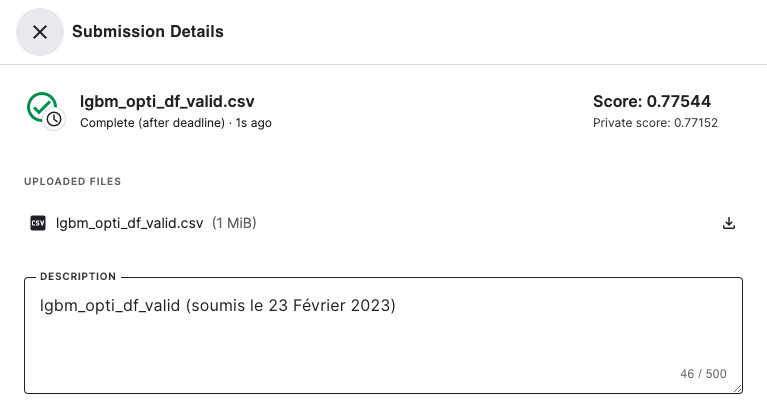

Le modèle lgbm_opti_class_weight est validé avec un score ROC-AUC de 0.775, qui est inférieur au meilleur score de la compétition (score ROC-AUC de 0,82) donc notre modèle de fait pas d'overfitting.

# 11. Préparation d'un jeu de données allegé pour le dashboard

## 11.1. Création du jeu de données : df_valid_tt_sample.csv

In [353]:
df_valid_tt.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,ANNUITY_INCOME_PERC,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_CNT_CREDIT_PROLONG_SUM,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EMERGENCYSTATE_MODE,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,INCOME_CREDIT_PERC,INCOME_PER_PERSON,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_SUM,INSTAL_COUNT,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,PAYMENT_RATE,POS_COUNT,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_MIN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_DAYS_DECISION_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_H

On va choisir des clients à qui le prêt est accordé et d'autres non.

In [354]:
df_valid_tt_target_0 = df_valid_tt.loc[df_valid_tt['TARGET'] == 0]

In [355]:
df_valid_tt_target_1 = df_valid_tt.loc[df_valid_tt['TARGET'] == 1]

In [356]:
df_valid_tt_target_0_rnd = df_valid_tt_target_0.sample(n = 50, random_state=42)

In [357]:
df_valid_tt_target_1_rnd = df_valid_tt_target_1.sample(n = 50, random_state=42)

In [367]:
df_valid_tt_sample = df_valid_tt_target_0_rnd.append(df_valid_tt_target_1_rnd)

In [368]:
df_valid_tt_sample = df_valid_tt_sample.sort_index()

In [371]:
df_valid_tt_sample.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,ANNUITY_INCOME_PERC,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_CNT_CREDIT_PROLONG_SUM,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EMERGENCYSTATE_MODE,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,INCOME_CREDIT_PERC,INCOME_PER_PERSON,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_SUM,INSTAL_COUNT,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,PAYMENT_RATE,POS_COUNT,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_MIN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_DAYS_DECISION_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_H

In [373]:
df_valid_tt_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 5675 to 306741
Columns: 194 entries, AMT_ANNUITY to index
dtypes: float64(138), int64(56)
memory usage: 152.3 KB


In [374]:
df_valid_tt_sample.to_csv('df_valid_tt_sample.csv')

In [376]:
df_valid_tt_sample.tail()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,ANNUITY_INCOME_PERC,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_CNT_CREDIT_PROLONG_SUM,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EMERGENCYSTATE_MODE,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,INCOME_CREDIT_PERC,INCOME_PER_PERSON,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_SUM,INSTAL_COUNT,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,PAYMENT_RATE,POS_COUNT,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_MIN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_DAYS_DECISION_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_H

## 11.2. Préparation du modèle pour détermination des features : SHAP

In [380]:
X_valid_tt_sample = df_valid_tt_sample.drop(columns='TARGET')

In [382]:
lgbm_opti_class_weight_explainer_sample = shap.Explainer(lgbm_opti_class_weight, X_valid_tt_sample, check_additivity=False)

In [383]:
shap_values_for_waterfall_df_valid_tt_sample = lgbm_opti_class_weight_explainer_sample(X_valid_tt_sample)

In [386]:
shap_values_for_waterfall_df_valid_tt_sample.shape

(100, 193)

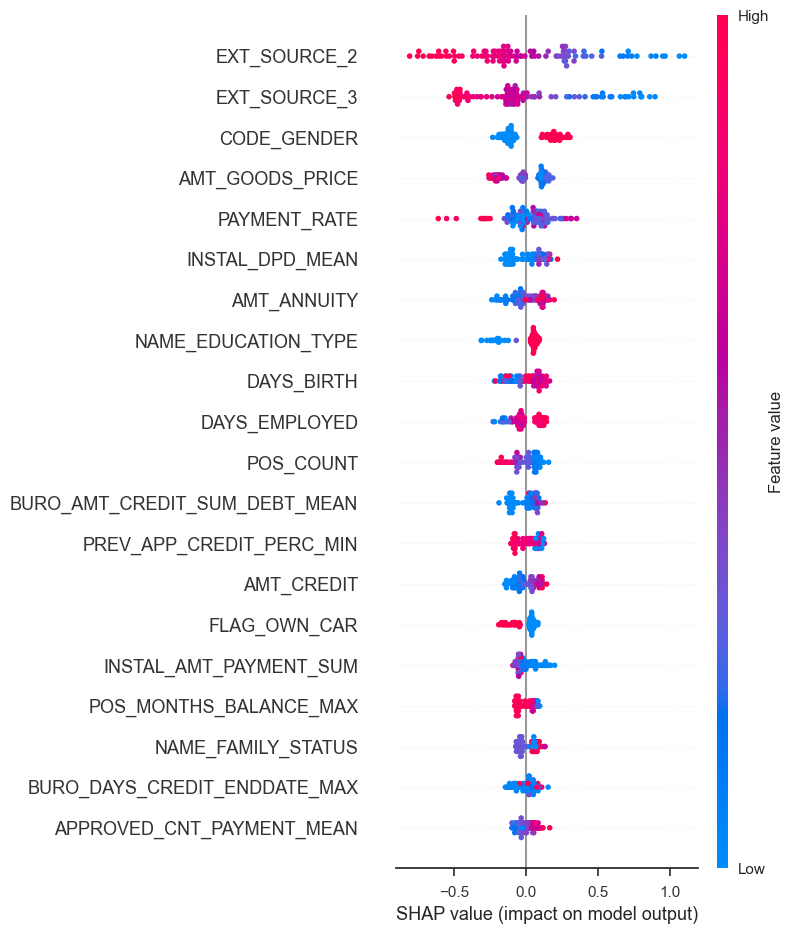

In [384]:
shap.summary_plot(shap_values_for_waterfall_df_valid_tt_sample, X_valid_tt_sample )

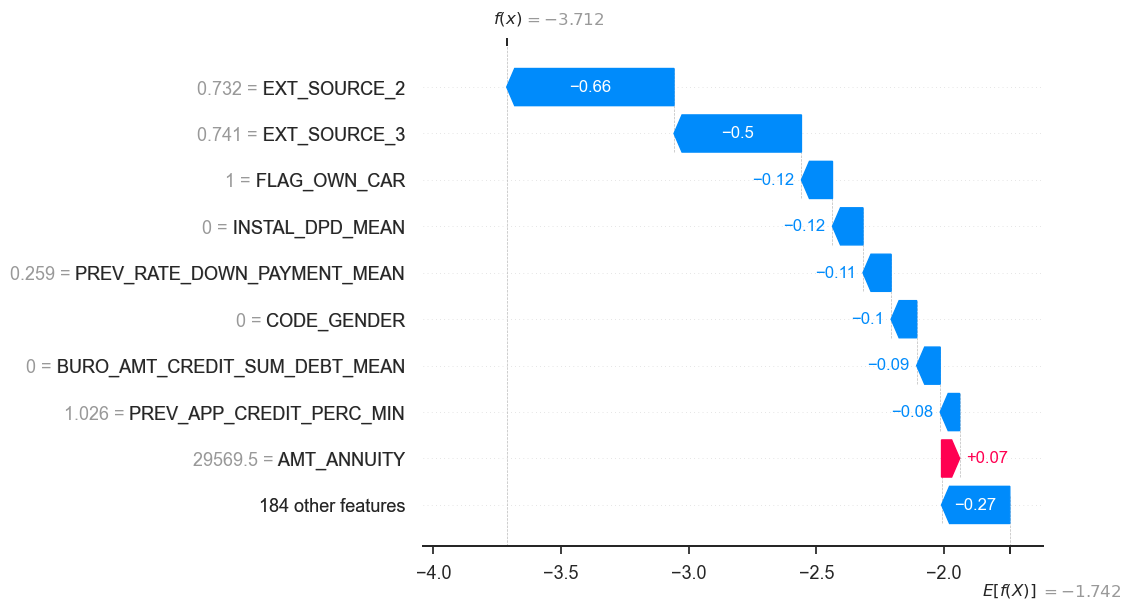

In [385]:
shap.plots.waterfall(shap_values_for_waterfall_df_valid_tt_sample[0])

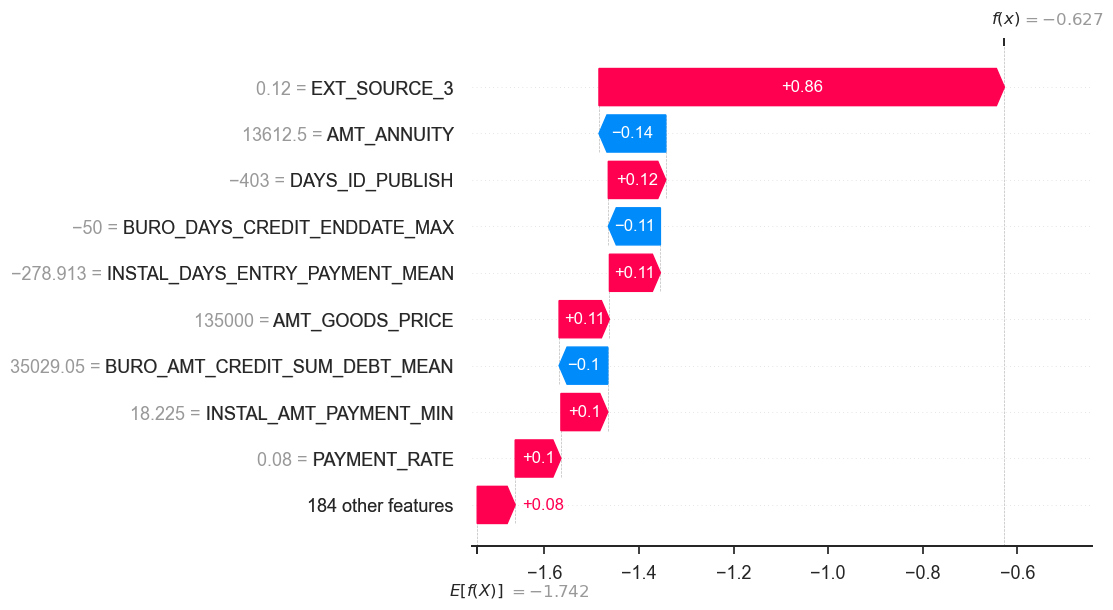

In [402]:
y_1 = shap.plots.waterfall(lgbm_opti_class_weight_explainer_sample(X_valid_tt_sample.loc[X_valid_tt_sample['index'] == 7395])[0])

## 11.3. Sérialisation du Tree Explainer SHAP 

In [397]:
type(lgbm_opti_class_weight_explainer_sample)

shap.explainers._tree.Tree

In [398]:
# serialize the Tree model
with open('lgbm_opti_class_weight_explainer_sample.pkl', 'wb') as f:
    pickle.dump(lgbm_opti_class_weight_explainer_sample, f)

In [400]:
# deserialize the Tree model
with open('lgbm_opti_class_weight_explainer_sample.pkl', 'rb') as f:
    lgbm_opti_class_weight_explainer_sample_reloaded = pickle.load(f)

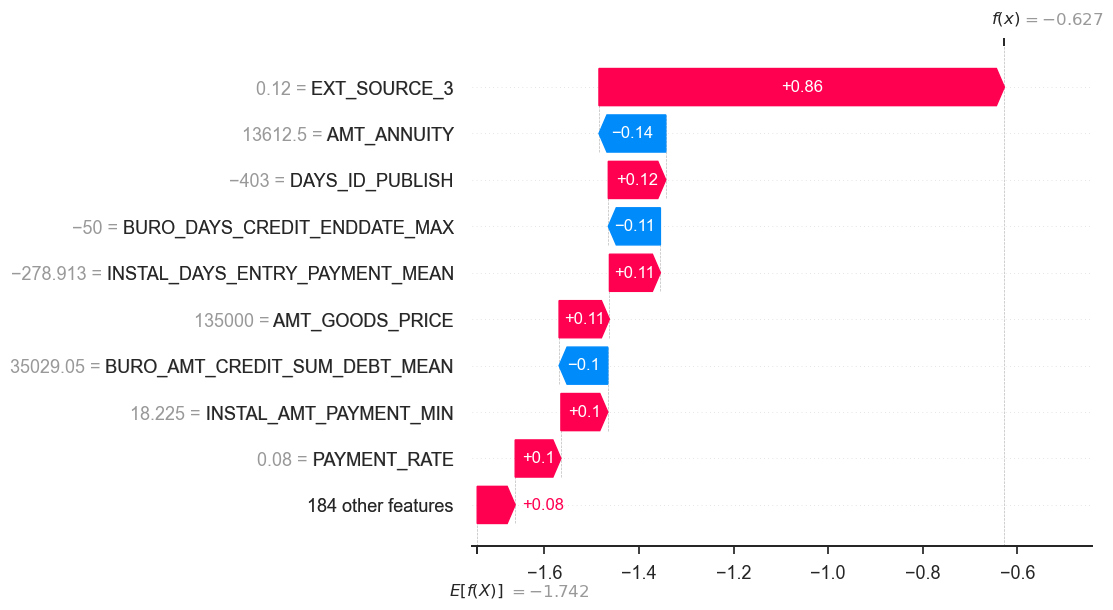

In [401]:
y_1 = shap.plots.waterfall(lgbm_opti_class_weight_explainer_sample_reloaded(X_valid_tt_sample.loc[X_valid_tt_sample['index'] == 7395])[0])

On retrouve le même résultat avec le modèle sauvé que précédemment à la fin de la section 11.2.

## 11.4. Préparation des graphes pour la comparaison avec d'autres clients

In [536]:
df_valid_tt_sample.loc[df_valid_tt_sample['index'] == 7395]['EXT_SOURCE_2']

7394    0.439416
Name: EXT_SOURCE_2, dtype: float64

In [537]:
df_valid_tt_sample.loc[df_valid_tt_sample['index'] == 7395]

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,ANNUITY_INCOME_PERC,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_CNT_CREDIT_PROLONG_SUM,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EMERGENCYSTATE_MODE,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,INCOME_CREDIT_PERC,INCOME_PER_PERSON,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_SUM,INSTAL_COUNT,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,PAYMENT_RATE,POS_COUNT,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_MIN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_DAYS_DECISION_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_H

In [559]:
import math

def feature_distribution_bar_chart(dataframe, feature, row_index):
    # Tracé de l'histogramme
    fig, ax = plt.subplots(figsize = (5,3))
    data = dataframe[feature]

    # Extract the row of the dataframe
    row = dataframe.loc[dataframe['index'] == row_index]
    
    # Extract the row of the dataframe
    row_value = float(row[feature])

    # Annotations (on tracer l'histogramme mais c'est juste pour récupérer la valeur ymax)
    y, x, _ = plt.hist(data)
    ymax = y.max()
    ax.text(row_value, ymax/2, " ← Customer " + str(row_index), size = 10, alpha = 1, color = 'blue')

    # Tracé des pourcentiles en rouge
    ax.axvline(row_value, color='blue', linestyle = "--")

    # Tracé de l'histogramme (pour écraser le 1er tracé de l'histogramme plus haut)
    plt.hist(data, color = "skyblue", ec="white") # Crée l'histogramme
    plt.title(feature)
    fig = plt.show() # Affiche l'histogramme
    return fig

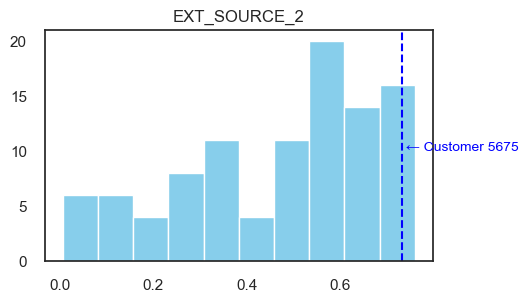

In [560]:
bar_chart = feature_distribution_bar_chart(df_valid_tt_sample, 'EXT_SOURCE_2', 5675)

In [561]:
import math

def feature_distribution_boxplot(dataframe, feature, row_index):
    # Extract the row of the dataframe
    row = dataframe.loc[dataframe['index'] == row_index]
    
    # Extract the row of the dataframe
    row_value = float(row[feature])

    fig, ax = plt.subplots(figsize = (5,3))

    # Tracé du boxplot
    plt.xticks(rotation=90)
    data = dataframe[feature]
    min_raw = round(dataframe[feature].min())
    min_r = round(min_raw, abs(1 - (len(str(min_raw)))))
    max_raw = round(dataframe[feature].max())
    max_r = round(max_raw, abs(1 - (len(str(max_raw)))))
    step = (max_r - min_r) / 20
    if (step != 0):
        plt.xticks(np.arange(min_r, max_r, step))
        red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='black')
        mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='black')
        
        ax = sns.boxplot(x = data, orient="h", color='skyblue', flierprops=red_circle, showmeans=True, meanprops=mean_shape)
        ax.set_title(feature)
        if feature == 'PAYMENT RATE':
            ax.text(row_value, 1.04, "Customer " + str(row_index) + "\n↓", size=10, ha="center", color='blue')
        else:
            ax.text(row_value, -0.02, "Customer " + str(row_index) + "\n↓", size=10, ha="center", color='blue')
    else:
        red_circle = dict(markerfacecolor='red', marker='o')
        mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='black')
        
        plt.boxplot(x=dataframe[feature], vert=False, flierprops=red_circle, 
             showmeans=True, meanprops=mean_shape)
        plt.title(feature)
        if feature == 'PAYMENT RATE':
            plt.text(row_value, 1.04, "Customer " + str(row_index) + "\n↓", size=10, ha="center", color='blue')
        else:
            plt.text(row_value, -0.02, "Customer " + str(row_index) + "\n↓", size=10, ha="center", color='blue')
    fig = plt.show() # Affiche le boxplot
    return fig

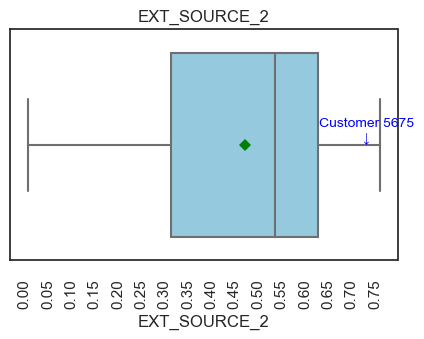

In [562]:
boxplot = feature_distribution_boxplot(df_valid_tt_sample, 'EXT_SOURCE_2', 5675)

## 11.5. Sérialisation des SHAP values

In [569]:
# Assume you have already calculated SHAP values and stored them in a variable named `shap_values`
# Save SHAP values to a pkl file
with open('shap_values.pickle', 'wb') as f:
    pickle.dump(shap_values_for_waterfall_df_valid_tt_sample, f)

In [570]:
# Load SHAP values from the pkl file
with open('shap_values.pickle', 'rb') as f:
    shap_values_reloaded = pickle.load(f)

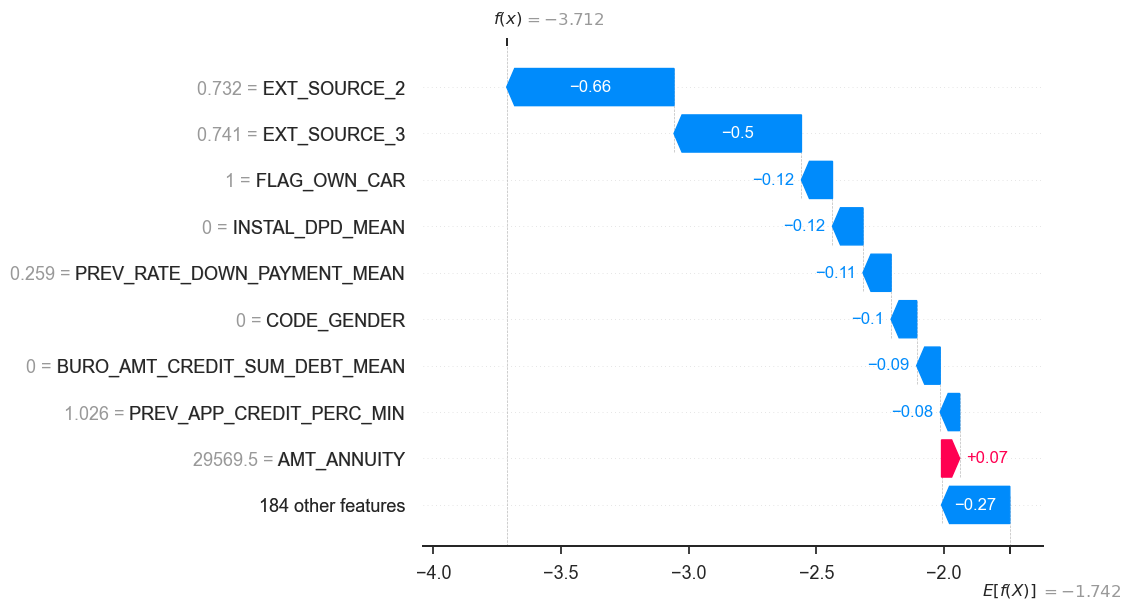

In [571]:
shap.plots.waterfall(shap_values_reloaded[0])

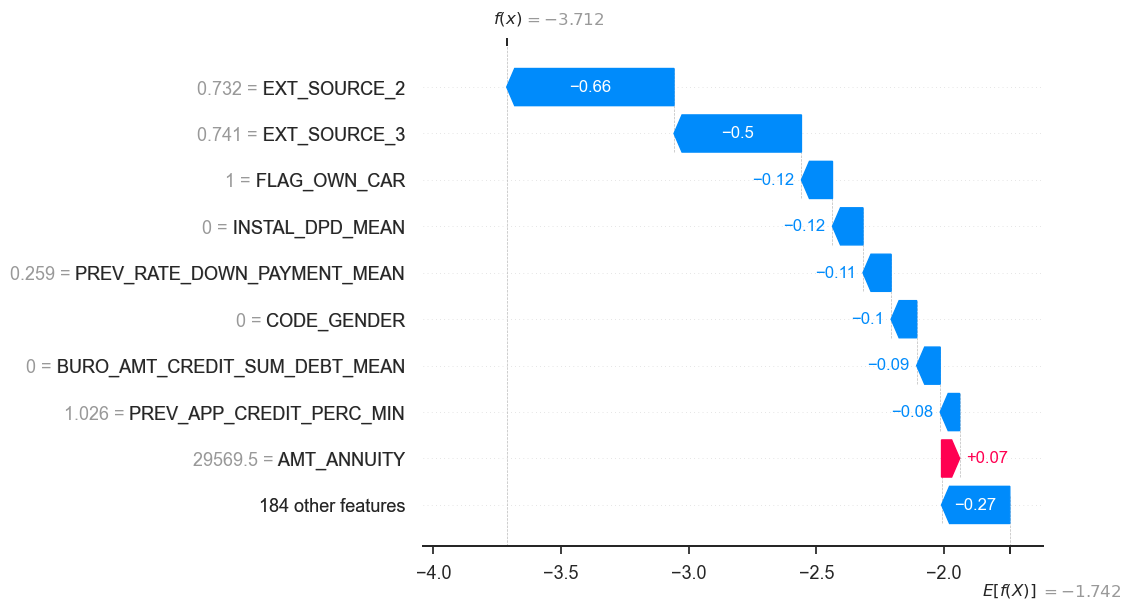

In [572]:
shap.plots.waterfall(shap_values_for_waterfall_df_valid_tt_sample[0])